In [ ]:
%matplotlib inline
#%matplotlib nbagg # JupyterLabでは上手く動かないので今回は使わない。
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
import numpy as np
from matplotlib.animation import ArtistAnimation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import Audio
import random

import sympy as sym
# Jupyter Notebook上で、レンダリングされた結果を表示する
sym.init_printing()

In [ ]:
def return_fft(x,dt,N):
    F = np.fft.fft(x) # 変換結果
    freq = np.fft.fftfreq(N, d=dt) # 周波数
    Amp = np.abs(F/(N/2)) # 振幅
    return(F, freq, Amp)

def return_ifft(F,N):
    f_time = np.fft.ifft(F,N).real # フーリエ逆変換して実部だけ取り出し
    return f_time

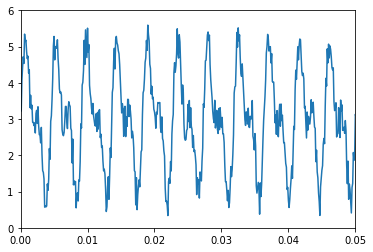

In [ ]:
N = 1024 * 10         # サンプル数
dt = 0.0001          # サンプリング周期 [s]
f1, f2 = 220, 440    # 周波数 [Hz] # 中央から一オクターブ低いラ、中央ラ

t = np.arange(0, N*dt, dt) # 時間 [s]
x = 1.5*np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) + 3 # 信号

for i in range(len(x)):
    x[i] += random.random()- 0.5 # randomは 0.0から1.0の間の値を生み出すので、それを -0.5から0.5にしている

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1) 
ax.plot(t, x)
ax.axis([-0.0,0.05,-0.0,6.0]) 
plt.show()

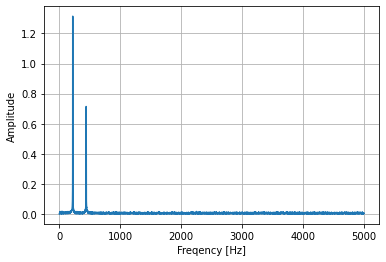

In [ ]:
F, F_freq, F_Amp = return_fft(x,dt,N)

fig, ax = plt.subplots()
ax.plot(F_freq[1:int(N/2)], F_Amp[1:int(N/2)]) # plot(X,Y)
ax.set_xlabel("Freqency [Hz]")
ax.set_ylabel("Amplitude")
ax.grid()
plt.show()

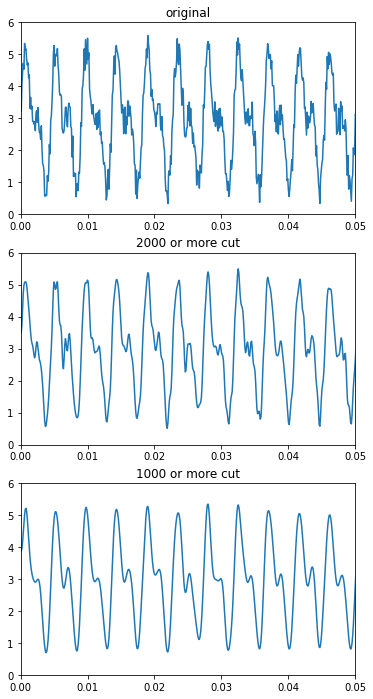

In [ ]:
# 高周波成分の除去
F1 = F.copy()
F2 = F.copy()

for i in range(len(F_freq)):
    if np.abs(F_freq[i]) > 1000: # 周波数（F_freq[i])が指定の値以上の時
        F1[i] = 0

for i in range(len(F_freq)):
    if np.abs(F_freq[i]) > 2000:
        F2[i] = 0

result_wave_1 = return_ifft(F1,N) # フーリエ逆変換
result_wave_2 = return_ifft(F2,N)

fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(3,1,1) 
ax.plot(t, x)
ax.axis([-0.0,0.05,-0.0,6.0]) 
plt.title("original")

ax = fig.add_subplot(3,1,2) 
ax.plot(t, result_wave_2)
ax.axis([-0.0,0.05,-0.0,6.0])
plt.title("2000 or more cut")

ax = fig.add_subplot(3,1,3) 
ax.plot(t, result_wave_1)
ax.axis([-0.0,0.05,-0.0,6.0])
plt.title("1000 or more cut")
plt.show()

In [ ]:
fig.savefig('./noise.svg')

In [ ]:
class ImagePress():       # これ、クラスで実装する必要ある？・全体的に変数名が雑

    def __init__(self, n=8): # n(ピクセル数)を引数で受け取れるようになっているが、デフォルトが好ましい(?)
        self.n = n
        def matrix_T(i, j):                                       # 回りくどい。素直に二重for文で良い
            k_i = 1/np.sqrt(2) if i == 1 else 1
            return np.sqrt(2/n)*k_i*np.cos((i-1)*(j-1/2)*np.pi/n) # 行列の要素生成
        vfunc = np.vectorize(matrix_T)                            # python関数をユニバーサル化
        index = range(1, self.n+1)
        jj, ii = np.meshgrid(index, index)   # (n*n)の行列が2個できる(行・列の順なので、逆順)
        self.T = vfunc(ii, jj)               # それぞれの行列の要素を順番に取ってくれる

    def dct_2(self, matrix): # 離散コサイン変換
        return self.T.dot(matrix).dot(self.T.T) # 変数名にTを使うべきではなかった(?)

    def idct_2(self, matrix): # 逆離散コサイン変換
        return self.T.T.dot(matrix).dot(self.T)

    def press(self, matrix):                 # 改良すべき
        p = int(self.n/2)                    # どれくらい圧縮するか？
        p_mat = np.zeros(matrix.shape)       # 圧縮後の雛形
        for i in range(p):
            p_mat[i, :p-i] = matrix[i, :p-i] # 左上部分に順次dctの係数を代入
        return p_mat

    def rgb_split(self, img): # 何かある気もするがこれが一番いいのかもしれない
        r_img = img[:,:,0]
        g_img = img[:,:,1]
        b_img = img[:,:,2]
        return r_img, g_img, b_img

    def rgb_marge(self, r_img, g_img, b_img):    # 何かある気もするがこれが一番いいのかもしれない
        r_img_3 = r_img[:,:,np.newaxis]          # 分割の影響で次元数が欠落しているので、新しく追加
        g_img_3 = g_img[:,:,np.newaxis]
        b_img_3 = b_img[:,:,np.newaxis]
        rg = np.append(r_img_3, g_img_3, axis=2) # 一気に3つマージする方法が分からなかった・・・
        rgb = np.append(rg, b_img_3, axis=2)
        return rgb

    def img_row_split(self, img):               # 指定ピクセル数で割り切れなかった時のことを考えるべき
        i = 0
        for _ in range(int(img.shape[0]/self.n)):
            img_row = img[i:i+self.n,:]
            yield img_row
            i += self.n

    def img_col_split(self, img):               # 指定ピクセル数で割り切れなかったことを考えるべき
        i = 0
        for _ in range(int(img.shape[1]/self.n)):
            img_col = img[:,i:i+self.n]
            yield img_col
            i += self.n

    def block_img_press(self, img):        # うーん、出来上がったもの見ると手順通りになっているけど・・・
        rgb = []
        for color in self.rgb_split(img):             # rgbの分割
            color_dash = self.dct_2(color)            # dctで変換(_2は二次元の意)
            color_press = self.press(color_dash)      # 高周波情報を削除
            new_color = self.idct_2(color_press)      # 元の画像形式に戻す
            rgb.append(new_color)
        return self.rgb_marge(rgb[0], rgb[1], rgb[2]) # rgbをマージして返す

    def img_press(self, img):  # 指定ピクセル分割→圧縮の順を繰り返している(yield) 分割は一気にやった方が良い(?)
        pressed_image = np.empty((0, img.shape[1], 3))            # 圧縮画像の雛形生成
        for i_r in self.img_row_split(img):                       # 横長の一枚(高さ:self.n)
            image_row = np.empty((i_r.shape[0], 0, 3))            # 圧縮後の横長の画像の雛形(すぐ捨てる)
            for i_c in self.img_col_split(i_r):                   # (self.n*self.n)の大きさの画像に分割される
                res_img = self.block_img_press(i_c)               # 圧縮
                image_row = np.append(image_row, res_img, axis=1) # 横長の一枚に保存
            pressed_image = np.append(pressed_image, image_row, axis=0) # 出来上がった横長の一枚を雛形に保存
        # この処理の妥当性
        pressed_image = np.round(pressed_image)                         # 四捨五入
        pressed_image = np.where(pressed_image>255, 255, pressed_image) # 0~255の範囲外の出力をカット
        pressed_image = np.where(pressed_image<0, 0, pressed_image)
        return pressed_image.astype(np.uint8)

In [ ]:
from PIL import Image

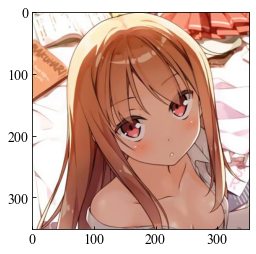

In [ ]:
img = Image.open("./org.jpg") # 縦横のピクセル数は8の倍数の画像
img_list = np.asarray(img)
plt.imshow(img_list);

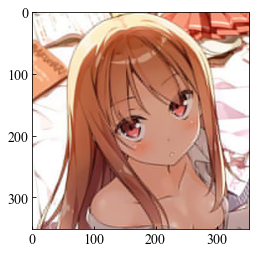

In [ ]:
pressed_image = ImagePress().img_press(img_list)
plt.imshow(pressed_image);

In [ ]:
Image.fromarray(pressed_image).save('./DCT.jpg')